In [3]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
from scipy import stats

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.diagnostics import true_vs_estimated
from bayesflow.exceptions import ConfigurationError

from bayesflow.applications.priors import GaussianMeanPrior, TPrior, GaussianMeanCovPrior
from bayesflow.applications.simulators import GaussianMeanSimulator, MultivariateTSimulator, GaussianMeanCovSimulator

In [178]:
class FullCovPrior:
    def __init__(self, D, nu=None, mu_0=0, lamda=1.0):
        self.D = D
        self.nu = nu or D+1
        self.mu_0 = mu_0
        self.lamda = lamda
        
        self.Psi = np.eye(D) * 1.0  # add parameter?
        self.cov_prior = stats.invwishart(nu, Psi)

    def __call__(n_sim):
        cov = (1.0/lamda) * self.cov_prior.rvs(n_sim)
        tril_cov = tf.linalg.cholesky(cov)
        mu = tfp.distributions.MultivariateNormalTriL(mu_0, tril_cov).sample()
        return mu, cov

In [247]:
def param_transform_full_cov(theta):
    means, cov = theta
    means = np.array(means)
    n_sim, D = means.shape
    cov = np.array(cov)
    cov = cov[np.tril(cov).nonzero()].reshape(n_sim, -1)
    return np.concatenate([means, cov], axis=1)

In [253]:
D=5
((D**2+D)//2 + D)

20

In [263]:
D = 3

#########

def param_transform_full_cov(theta):
    means, cov = theta
    means = np.array(means)
    n_sim, D = means.shape
    cov = np.array(cov)
    cov = cov[np.tril(cov).nonzero()].reshape(n_sim, -1)
    return np.concatenate([means, cov], axis=1)

prior = GaussianMeanCovPrior(D=D, a0=D+1, b0=1, m0=0, beta0=1)
simulator = GaussianMeanCovSimulator()
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=((D**2+D)/2 + D),   # twice the required
                                   activation_out=None  # linear
)


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': ((D**2+D)//2 + D),   # lower diagonal cov (1+2+...+D) and D means
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      learning_rate=0.0001,
                      checkpoint_path='export_ckpt/full_cov'
                     )

Initializing networks from scratch.


In [264]:
losses = trainer.train_rounds(epochs=10, rounds=5, sim_per_round=10000, batch_size=1024, n_obs=100)

Simulating initial 10000 data sets...
Converting 10000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 20000
Converting 20000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/20 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 30000
Converting 30000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/30 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/30 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/30 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/30 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/30 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/30 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/30 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/30 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/30 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/30 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 40000
Converting 40000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 50000
Converting 50000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas


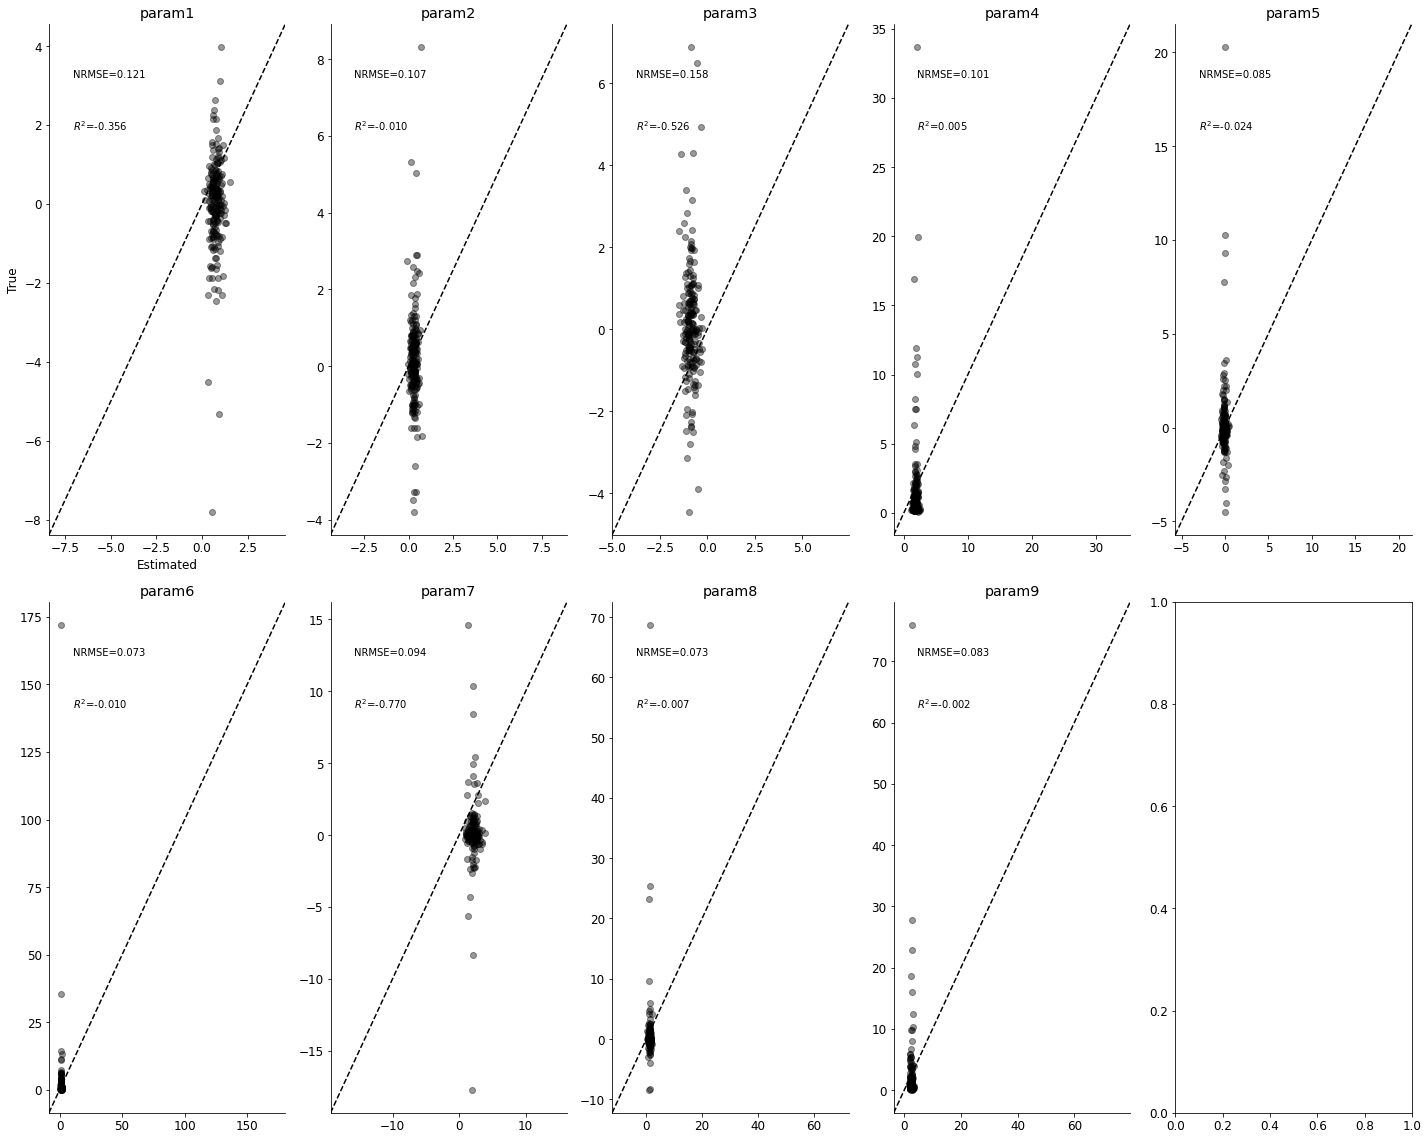

In [265]:
theta, x = generative_model(200, 100)
param_samples = trainer.network.sample(x, n_samples=200)
param_means = param_samples.mean(axis=0)

# true parameters
print("BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas")
true_vs_estimated(theta, param_means,
                  ['param{}'.format(i) for i in range(1, param_means.shape[1]+1)],
                  figsize=(20,16))
# idea: align the covariance estimate plots like a lower-triangular cov matrix